In [1]:
'''
    1. use cosine similarity to cross compare the medical embeddings and general embeddings for the same term
    2. thresholding, low similarity -> likely medical term, high similarity -> likely genral terms
    3. k-means clustering, then identify terms
    4. manual validation
'''

'\n    1. use cosine similarity to cross compare the medical embeddings and general embeddings for the same term\n    2. thresholding, low similarity -> likely medical term, high similarity -> likely genral terms\n    3. k-means clustering, then identify terms\n    4. manual validation\n'

In [2]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

/Users/rolf/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
'''
    Process input embeddings, generate 'structured_attributes' to be compared
'''
structured_medcat_embeddings = pd.read_csv("input/structured_keywords/structured_med_embeddings_freq.csv")
structured_spacy_embeddings = pd.read_csv("input/structured_keywords/structured_general_embeddings.csv")

structured_medcat_attributes = structured_medcat_embeddings['Attribute']
structured_spacy_attributes = structured_spacy_embeddings['Attribute']
# get common structured attributes, and compare for each embeddings
structured_attributes = list(set(structured_medcat_attributes).intersection(set(structured_spacy_attributes)))

print(f"Found {len(structured_attributes)} common attributes.")
structured_attributes

Found 65 common attributes.


['Days from randomization to date when participant was last known to be free from lung cancer',
 'Race',
 'Cancer in Right upper lobe',
 'Lung cancer grade',
 'Technical parameters: Effective mAs',
 'AJCC 7th edition stage',
 'Study Year of Diagnosis',
 'Cancer in Lingula',
 'Abnormality description',
 'ICD-O-3 Morphology',
 'VALCSG Stage (Small cell only)',
 'Result of screen associated with the first confirmed lung cancer diagnosis',
 'Pathologic Stage',
 'Clinical T for staging',
 'Lung cancer type from ICD-O-3 morphology',
 'Cancer in Left Hilum',
 'Cancer in Right middle lobe',
 'Clinical Stage',
 'Stage ("Best": Path if avail., else Clin)',
 'ICD-O-3 Behavior',
 'Technical parameters: Display FOV in cm',
 'Technical parameters: mA',
 'Is this cancer the first lung cancer diagnosed?',
 'Tumor size (mm) - Pathology',
 'Cancer in Right main stem bronchus',
 'Order of this lung cancer among all lung cancers for this participant',
 'Cancer in Other Location',
 'Abnormality number (uni

In [4]:
'''
    Manually filter out some keywords
'''
filtered = []
keywords_to_exclude = ["pathology", "cancer", "clinical", "icd-o-3", "AJCC"]

for attribute in structured_attributes:
    if not any(keyword in attribute.lower() for keyword in keywords_to_exclude):
        filtered.append(attribute)

structured_attributes = filtered

In [5]:
def parse_embedding(embedding_str):
    try:
        embedding = list(map(float, embedding_str.strip('[]').split()))
    except ValueError:
        embedding = None
    return embedding


structured_medcat_embeddings['Parsed_Embeddings'] = structured_medcat_embeddings['UMLS_Embeddings'].apply(parse_embedding)
structured_spacy_embeddings['Parsed_Embeddings'] = structured_spacy_embeddings['UMLS_Embeddings'].apply(parse_embedding)

results = []
for attribute in structured_attributes:
    # for MedCAT embedding
    medcat_row = structured_medcat_embeddings[structured_medcat_embeddings['Attribute'] == attribute]
    medcat_embedding = medcat_row['Parsed_Embeddings'].values[0] if not medcat_row.empty else None
    
    # for SpaCy embedding
    spacy_row = structured_spacy_embeddings[structured_spacy_embeddings['Attribute'] == attribute]
    spacy_embedding = spacy_row['Parsed_Embeddings'].values[0] if not spacy_row.empty else None
    
    # get cosine similarity
    if medcat_embedding is not None and spacy_embedding is not None:
        similarity = cosine_similarity([medcat_embedding], [spacy_embedding])[0, 0]
        medcat_pretty_name = medcat_row['pretty_name'].values[0]
        spacy_pretty_name = spacy_row['pretty_name'].values[0]

        results.append({
            "Attribute": attribute,
            "MedCAT Pretty Name": medcat_pretty_name,
            "SpaCy Pretty Name": spacy_pretty_name,
            "Cosine Similarity": similarity
        })

results

[{'Attribute': 'Race',
  'MedCAT Pretty Name': 'Indigenous People Of Alaska',
  'SpaCy Pretty Name': 'African-American',
  'Cosine Similarity': 0.7215234680400757},
 {'Attribute': 'Technical parameters: Effective mAs',
  'MedCAT Pretty Name': 'Techniques Values',
  'SpaCy Pretty Name': 'CT',
  'Cosine Similarity': 0.8712888323675464},
 {'Attribute': 'AJCC 7th edition stage',
  'MedCAT Pretty Name': 'Carcinoma Of The Lung',
  'SpaCy Pretty Name': 'first',
  'Cosine Similarity': 0.7636685378688962},
 {'Attribute': 'Study Year of Diagnosis',
  'MedCAT Pretty Name': 'Diagnosing',
  'SpaCy Pretty Name': 'The initial year',
  'Cosine Similarity': 0.8344475957834161},
 {'Attribute': 'Abnormality description',
  'MedCAT Pretty Name': 'Numbering System',
  'SpaCy Pretty Name': 'LSS',
  'Cosine Similarity': 0.7655980612792388},
 {'Attribute': 'VALCSG Stage (Small cell only)',
  'MedCAT Pretty Name': 'Cellular Structures',
  'SpaCy Pretty Name': 'VALCSG',
  'Cosine Similarity': 0.8736212654811377

In [6]:
similarity_df = pd.DataFrame(results)
similarity_df = similarity_df.sort_values(by='Cosine Similarity', ascending=True)
similarity_df.to_csv("structured_attribute_similarity.csv", index=False)
similarity_df.head(10)


,Attribute,MedCAT Pretty Name,SpaCy Pretty Name,Cosine Similarity
15,Overall diagnostic quality of CT examination,Diagnostic Quality,CT,0.701980
0,Race,Indigenous People Of Alaska,African-American,0.721523
2,AJCC 7th edition stage,Carcinoma Of The Lung,first,0.763669
4,Abnormality description,Numbering System,LSS,0.765598
13,Age at randomization (in years; whole number),Current Chronological Age,years,0.769398
23,Summary staging,Carcinoma Of The Lung,ACRIN,0.786808
14,Margins,4 Mm,Description,0.789463
22,Location of epicenter,Calcified Qualifier,Location,0.802981
19,Smoking status at T0,Clinical Trials Unspecified,Cigarette,0.808737
7,"Stage (""Best"": Path if avail., else Clin)",Diagnostic Neoplasm Staging,AJCC,0.822794


In [7]:
'''
    Clustering Analysis
'''
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np


In [14]:
combined_embeddings = []

for attribute in structured_attributes:
    # embedding from MedCAT
    medcat_row = structured_medcat_embeddings[structured_medcat_embeddings['Attribute'] == attribute]
    medcat_embedding = medcat_row['Parsed_Embeddings'].values[0] if not medcat_row.empty else None
    
    # embedding from SpaCy
    spacy_row = structured_spacy_embeddings[structured_spacy_embeddings['Attribute'] == attribute]
    spacy_embedding = spacy_row['Parsed_Embeddings'].values[0] if not spacy_row.empty else None
    if medcat_embedding is not None and spacy_embedding is not None:
        combined_embeddings.append(medcat_embedding + spacy_embedding)

combined_embeddings = np.array(combined_embeddings)
combined_embeddings


array([[ 7.27539510e-03, -3.80534410e-01, -5.24915755e-01, ...,
         1.56078488e-04,  4.07521240e-03,  6.82988688e-02],
       [ 9.95533243e-02, -4.63148355e-01, -4.65462416e-01, ...,
         4.84121382e-01, -9.93228182e-02,  1.12448722e-01],
       [-2.18688220e-01, -4.56627533e-02, -2.03337148e-01, ...,
         1.56397805e-01, -1.25922158e-01, -2.80321479e-01],
       ...,
       [-2.18688220e-01, -4.56627533e-02, -2.03337148e-01, ...,
         3.95900369e-01,  2.15559453e-01, -8.12749118e-02],
       [ 2.25044385e-01, -1.24098048e-01,  6.80510327e-02, ...,
         4.68173712e-01, -1.55697510e-01, -2.19161734e-01],
       [ 2.21050888e-01, -3.21663737e-01, -5.06004840e-02, ...,
         2.07543626e-01,  1.01711322e-02, -1.26946256e-01]])

In [15]:
from sklearn.cluster import AgglomerativeClustering

hierarchical = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels = hierarchical.fit_predict(combined_embeddings)

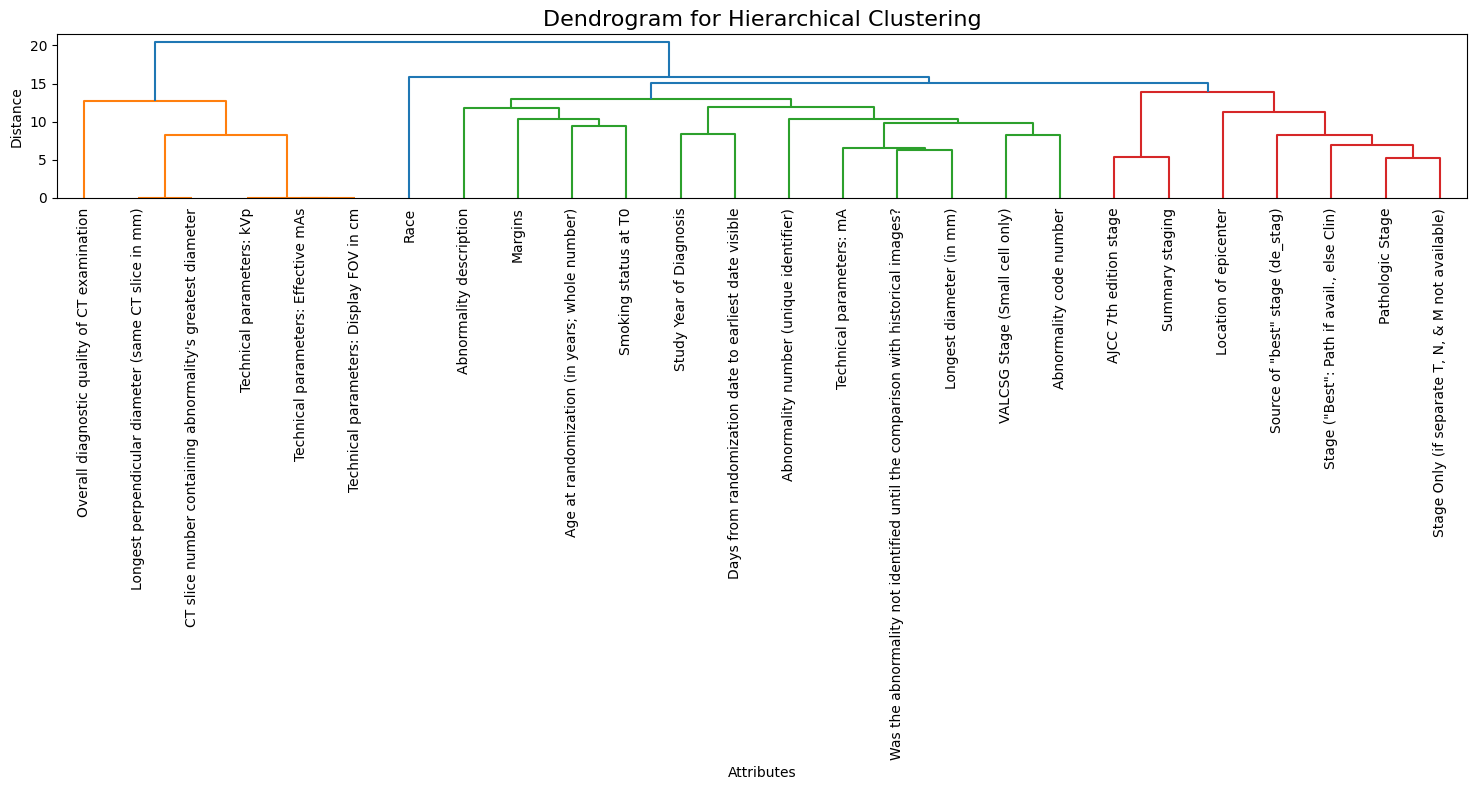

In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Compute the linkage matrix
linkage_matrix = linkage(combined_embeddings, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 8))
dendrogram(
    linkage_matrix,
    labels=structured_attributes,
    leaf_rotation=90,  # Rotate labels for readability
    leaf_font_size=10,  # Font size for labels
    color_threshold=0.7 * max(linkage_matrix[:, 2])  # Highlight the threshold
)
plt.title("Dendrogram for Hierarchical Clustering", fontsize=16)
plt.xlabel("Attributes")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()
